<a href="https://colab.research.google.com/github/Real1CM/MLassignment/blob/main/%E4%BD%9C%E4%B8%9A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 作业2 线性回归

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib

# 1. 加载训练集 (housing.data.txt 文件)
# 假设文件每行有13个特征和最后一个目标房价
with open('./housing.data.txt', 'r') as f:
    train_data = [line.strip().split() for line in f.readlines()]

# 转换为numpy数组
train_data = np.array(train_data, dtype=np.float32)

# 分离特征和目标房价
X_train = train_data[:, :-1]  # 前13列是特征
y_train = train_data[:, -1]   # 最后一列是目标房价

# 2. 加载测试集 (housing_data.csv 文件)
test_data = pd.read_csv('./housing_data.csv', skiprows = 1)

# 分离特征和目标房价
X_test = test_data.iloc[:, :-1].values  # 前13列是特征
y_test = test_data.iloc[:, -1].values   # 最后一列是目标房价

# 3. 数据预处理: 对特征和目标房价进行归一化
scaler_X = StandardScaler()  # 特征归一化
scaler_y = StandardScaler()  # 目标值归一化

# 对训练集进行归一化
X_train = scaler_X.fit_transform(X_train)
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))  # 归一化目标房价

# 对测试集进行归一化
X_test = scaler_X.transform(X_test)
y_test = scaler_y.transform(y_test.reshape(-1, 1))  # 归一化目标房价

# 转换为PyTorch张量
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# 4. 构建线性回归模型
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)  # 输入为13个特征，输出为1个值(房价)

    def forward(self, x):
        return self.linear(x)

model = LinearRegressionModel(X_train.shape[1])  # 输入维度为13

# 5. 定义损失函数和优化器
criterion = nn.MSELoss()  # 使用均方误差作为损失函数
optimizer = optim.SGD(model.parameters(), lr=0.01)  # 随机梯度下降优化器

# 6. 训练模型
num_epochs = 1000
for epoch in range(num_epochs):
    # 前向传播
    model.train()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 保存训练后的模型
torch.save(model.state_dict(), './linear_regression_model.pth')
joblib.dump(scaler_X, './scaler_X.pkl')  # 保存特征归一化模型
joblib.dump(scaler_y, './scaler_y.pkl')  # 保存目标归一化模型

# 7. 加载预训练模型并进行测试集预测
loaded_model = LinearRegressionModel(X_train.shape[1])
loaded_model.load_state_dict(torch.load('./linear_regression_model.pth'))
loaded_model.eval()  # 切换到评估模式

# 加载归一化模型
loaded_scaler_X = joblib.load('./scaler_X.pkl')
loaded_scaler_y = joblib.load('./scaler_y.pkl')

# 对测试集进行预测
with torch.no_grad():
    predicted = loaded_model(X_test_tensor).numpy()  # 预测的房价（归一化）
    predicted = loaded_scaler_y.inverse_transform(predicted)  # 反归一化预测结果
    y_test = loaded_scaler_y.inverse_transform(y_test_tensor)  # 反归一化真实房价

# 输出真实值和预测值对比
print("真实房价: ", y_test.flatten())
print("预测房价: ", predicted.flatten())


Epoch [100/1000], Loss: 0.3056
Epoch [200/1000], Loss: 0.2739
Epoch [300/1000], Loss: 0.2659
Epoch [400/1000], Loss: 0.2625
Epoch [500/1000], Loss: 0.2610
Epoch [600/1000], Loss: 0.2602
Epoch [700/1000], Loss: 0.2598
Epoch [800/1000], Loss: 0.2596
Epoch [900/1000], Loss: 0.2595
Epoch [1000/1000], Loss: 0.2594
真实房价:  [24.00000002 21.59999998 34.69999985 33.4000003  36.20000051 28.69999996
 22.90000001 27.10000011 16.50000015 18.90000005 15.00000004 18.90000005
 21.69999999 20.40000003 18.2        19.90000013 23.09999999 17.50000023
 20.19999988 18.2        13.59999994 19.60000011 15.20000006 14.5
 15.60000008 13.89999996 16.60000016 14.80000003 18.40000002 20.99999994
 12.70000042 14.5        13.19999991 13.10000045 13.49999993 18.90000005
 20.00000014 20.99999994 24.69999994 30.80000011 34.89999987 26.60000008
 25.29999998 24.69999994 21.19999995 19.30000008 20.00000014 16.60000016
 14.4        19.40000009 19.70000011 20.50000004 24.99999996 23.39999998
 18.90000005 35.40000045 24.6999

<ipython-input-11-67f58309aba5>:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('./linear_regression_model.pth'))


###### 可以看到训练好的模型保存在content目录下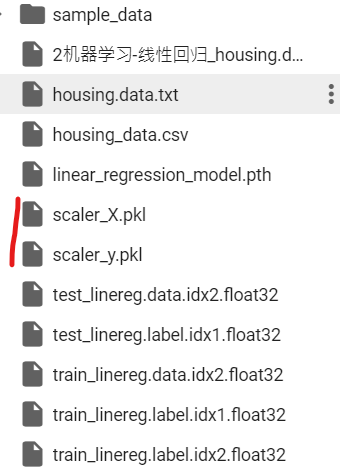

###### 在测试数据集中，可以看到房价和给出已有的房价有略微的变化，并不是完全符合。